In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from sklearn.decomposition import PCA
from neurodsp import sim
from neurodsp.spectral import compute_spectrum

import sys, os
sys.path.append('../')
from galaxybrain import ramsey 
import fooof
#for comparing PCA methods
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# fBm 

from https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.sim.sim_powerlaw.html#neurodsp.sim.sim_powerlaw

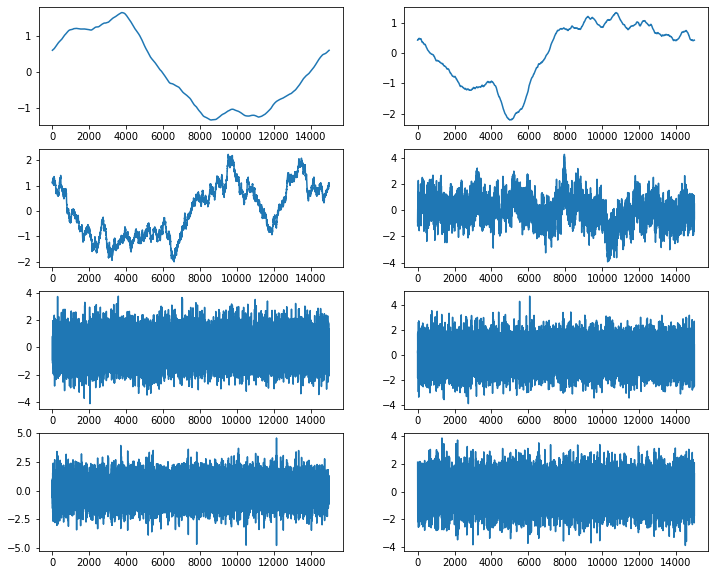

In [2]:
plt.figure(figsize=(12,10))
for n_i, i in enumerate(range(-4,4)):
    signal = sim.sim_powerlaw(n_seconds=30, fs=500, exponent=i)
    plt.subplot(4,2,n_i+1)
    plt.plot(signal)

### PCA on multiple "electrodes"

alpha = 2H + 1



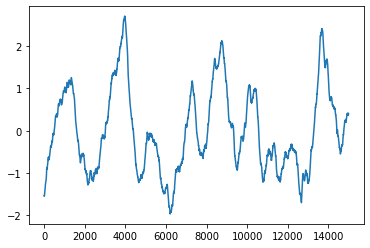

In [3]:
exp, num = -3, 20
signals = []
for i in enumerate(range(num)):
    signals.append(sim.sim_powerlaw(n_seconds=30, fs=500, f_range = [0.1,100], exponent=exp))

plt.plot(signals[1])
pca = PCA(n_components = num)
pca.fit(np.array(signals).T)
pc_ratios = pca.explained_variance_ratio_

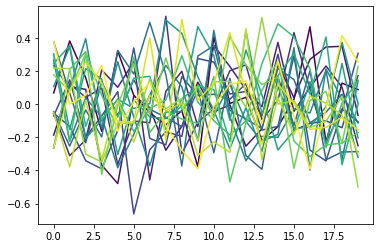

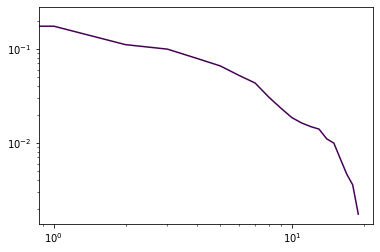

In [4]:
n = pca.components_.shape[0]
color = plt.cm.viridis(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

plt.figure()

plt.plot(pca.components_)

plt.figure()
plt.loglog(pc_ratios)

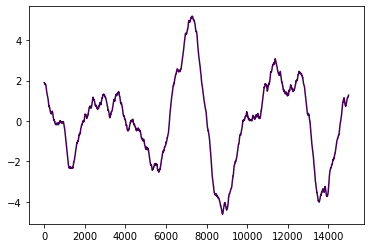

In [5]:
plt.plot(pca.components_[0]@np.array(signals))

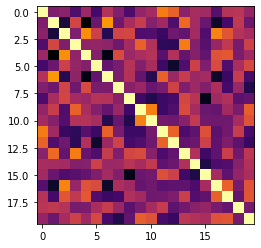

In [72]:
correlations = np.corrcoef(np.array(signals))

plt.figure()
plt.imshow(correlations, 'inferno')
plt.show()

# Vary fBm for exponent range

- Need to figure out FFT params

In [3]:
def pca(data, num):
    if type(data) != np.ndarray:
        data = np.array(data)
    
    pca = PCA(n_components = num)
    pca.fit(data.T)
    components, spec  = pca.components_, pca.explained_variance_ratio_
    return components, spec

def sim_and_fit(exponents = np.arange(-4,0.2,0.2), num = 100, pc_range = None, n_pc = 100, f_range = None, sum_sig = False):
    
    fs=500; nperseg=fs; noverlap=250; freqs = np.fft.rfftfreq(nperseg); 
    exponents = np.around(exponents, 1) #undo scientific notation
    signals = {}
    pca_results = {}
    fft_results = {}
    slopes = {}
    for exp in exponents:
        signals[exp] = []
        for i in range(num):
            signals[exp].append(sim.sim_powerlaw(n_seconds=60, fs=500, f_range = None, exponent=exp))

        pca_results[exp] = pca(signals[exp], num)
        
        if sum_sig:
            summed = np.array(signals[exp]).sum(axis = 0)
            fft_results[exp] = compute_spectrum(summed, fs, nperseg = nperseg, noverlap = noverlap)
            slopes[exp] = (ramsey.fooofy(np.arange(1,n_pc+1), pca_results[exp][1], pc_range, group = False)[0],ramsey.fooofy(freqs, fft_results[exp][1], f_range, group = False)[0])
        else:
            fft_results[exp] = compute_spectrum(np.array(signals[exp]), fs, nperseg = nperseg, noverlap = noverlap)

            slopes[exp] = (ramsey.fooofy(np.arange(1,n_pc+1), pca_results[exp][1], pc_range, group = False)[0],ramsey.fooofy(freqs, fft_results[exp][1].mean(0), f_range, group = False)[0])
        
    return slopes, pca_results, fft_results

slopes, pca_results, fft_results = sim_and_fit(sum_sig = False)
slopes2, pca_results2, fft_results2 = sim_and_fit(sum_sig = 1)

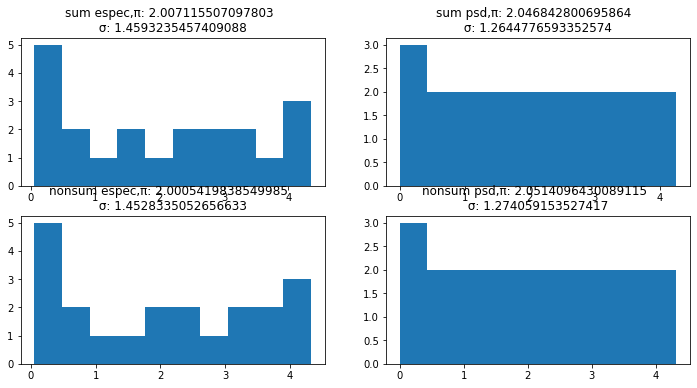

In [53]:
plt.figure(figsize=(12,6))
# colors = cm.get_cmap('cool',len(pca_results.keys()))(np.linspace(0,1,len(pca_results.keys())))
dat = {'sum':slopes2, 'nonsum':slopes}
pi=1
for k in dat.keys():
    for e in enumerate(('espec','psd')):
        plt.subplot(2,2,pi)
        data = [v[e[0]] for v in dat[k].values()]
        plt.hist(data); plt.title(f'{k} {e[1]},π: {np.mean(data)}  \n σ: {np.std(data)} ')
        pi+=1


In [59]:
sig4= []
for i in range(100):
    sig4.append(sim.sim_powerlaw(n_seconds=60, fs=500, f_range = None, exponent=-4.0))
sig4 = np.array(sig4)

In [28]:
pca_results['-4.0'][0].shape

(100, 100)

In [ ]:
plt.figure(figsize=(10,10))
plt.loglog(fft_results[exp][0], fft_results[exp][1].T)
plt.show()

In [214]:
fft_results[exp][1].shape

(100, 251)

In [38]:
pca_results2.keys()

dict_keys([-4.0, -3.8, -3.6, -3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0])

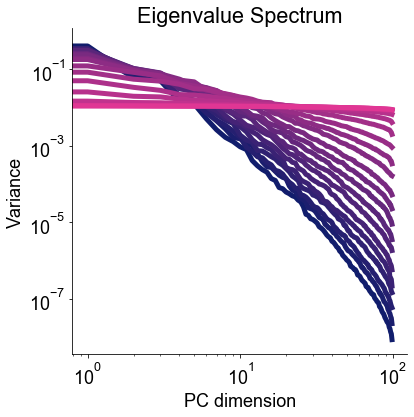

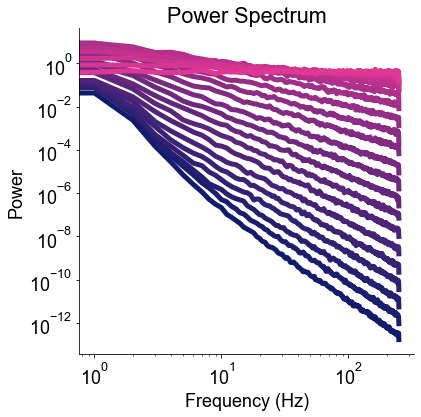

<Figure size 432x288 with 0 Axes>

In [23]:
font = {'family' : 'Arial',
       'weight' : 'regular',
       'size'   : 18}
plt.rc('font', **font)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])

exponents = np.around(np.arange(-4,0.2,0.2),1) #no sci notation
n_ = exponents.shape[0]

color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)


save_e, save_p = 0,0
# E SPEC
f = plt.figure(figsize=(6,6))
for i, exp in enumerate(exponents):
    plt.loglog(pca_results2[exp][1], linewidth=5) 

    
plt.title('Eigenvalue Spectrum')
plt.xlabel('PC dimension'); plt.ylabel('Variance')
plt.show()
if save_e:
    f.savefig('../../conferences/fbm_espec', dpi = 300)

## PSD
f = plt.figure(figsize=(6,6))
for i, exp in enumerate(exponents):
    #plt.loglog(fft_results[exp][1].mean(0), linewidth=5) #in non summing case
    plt.loglog(fft_results2[exp][1], linewidth=5) # this requires reshaping and probably averaging, if plotting the non summed trials

plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power')
plt.show()
if save_p:
    f.savefig('../../conferences/fbm_pspec', dpi = 300)
    #plt.title(r'$\alpha$ = '+exp)

#plt.xlim([1,70])    
plt.tight_layout()    
plt.show()

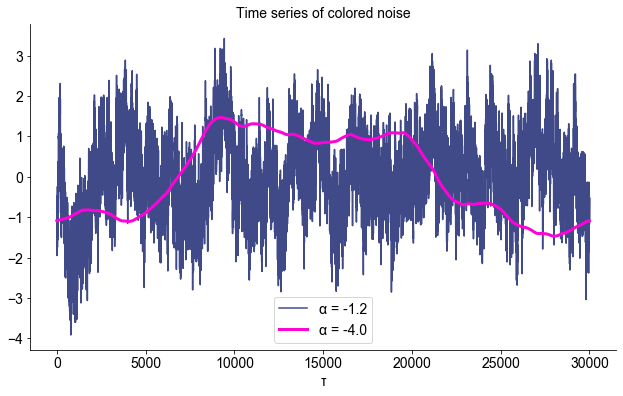

In [195]:
save = 1
f = plt.figure(figsize = (10.5,6))
plt.plot(signals['-1.2'][0].T, color = '#111d6c', label = '\u03B1 = -1.2', alpha = 0.8)
plt.plot(signals['-4.0'][0].T, color = '#fc03d7', lw = 3, label = '\u03B1 = -4.0')
plt.legend(fontsize = 14)
plt.xlabel('\u03C4')
plt.title('Time series of colored noise', fontsize = 14)
plt.show()

if save:
    f.savefig('../../conferences/sampleseries', dpi = 300)

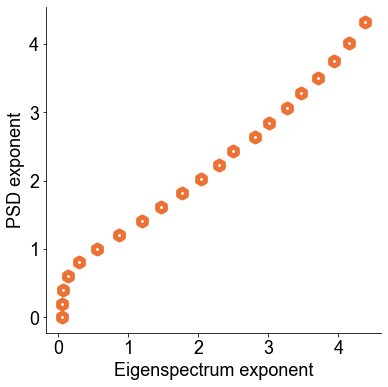

In [9]:
save = 0
x, y = [], []
for k in slopes2.keys():
    x.append(slopes2[k][0]) #Espec exps
    y.append(slopes2[k][1]) #PSD exps | just input k for ground truth
y = [abs(float(n)) for n in y] #converting to positive numbers (this is the exponent).  Using abs because they are all negative

plt.figure(figsize = (6,6))

sc = plt.scatter(x,y, marker = 'h', c = 'white', edgecolors = '#eb7134', s= 80, linewidths = 5)
plt.xlabel('Eigenspectrum exponent'); plt.ylabel('PSD exponent') 
plt.locator_params(axis='y', tight=True, nbins=8); #plt.locator_params(which='x', tight=True, nbins=8)

if save:
    plt.savefig('../../conferences/psd_vs_eig', dpi = 300)
plt.show()

# Gaussian sim to check PC spectrum drop off

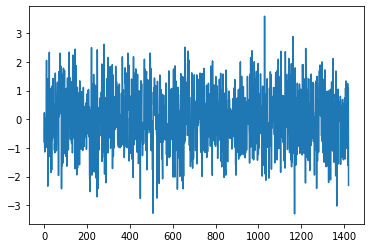

In [3]:
y = np.random.normal(size=1462)
burn_in = 20
plt.plot(y[burn_in:-burn_in])

## Manual fBm

## SSA

from http://karthur.org/2017/learning-for-time-series-ssa-vs-pca.html

How to apply an optimal window and step size automatically?

In [36]:
def delay_embed(data, m, step = 1, norm = True):
    """m is window length"""
    data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    traj_mat = np.empty((0,m)) #initialize delay embedded trajectory matrix
    for i in range(n):
        window_i = data[i*step:i*step + m]
        traj_mat = np.append(traj_mat, [window_i], axis=0 )
    
    if norm:
        traj_mat = (1/(nt**0.5)) * traj_mat #normalize by 1/sqrt(n)
    return traj_mat

def SSA(data, m, step, norm = True, return_traj = False):
    """Performs SSA on time series with window size m and inter-window step size"""
    if type(data) != np.ndarray:
        data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    
    traj_mat = delay_embed(data, m, step, norm)
    components, e_spectrum = pca(traj_mat, n)
#      =PCA(n_components = n)
#     pca.fit(traj_mat.T)
#     components = pca.components_
#     e_spectrum = pca.explained_variance_ratio_
    
    if not return_traj:
        return components, e_spectrum
    else:
        return components, e_spectrum, traj_mat

## Multi exponent test, SSA version

In [37]:
exponents = np.arange(-4,0.2,0.2)

signals2 = {} #1d now since only one fBm per exponent
ssa_results = {}
for exp in exponents:
    exp = round(exp, 1) #why is this even necessary
    signal = sim.sim_powerlaw(n_seconds=30, fs=500, f_range = None, exponent=exp)
        
    ssa_results[exp] = SSA(signal, m = 5000, step = 1000)

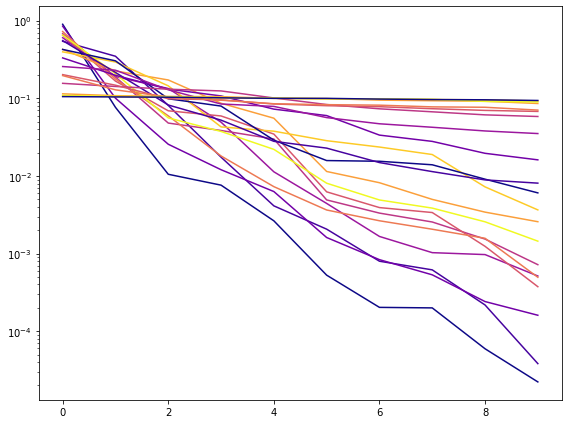

In [38]:
n_ = ssa_results['0.0'][0].shape[0]
color = plt.cm.plasma(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
plt.figure(figsize=(8,6))

for i, exp in enumerate(exponents):
    exp = round(exp, 1)
    plt.plot(ssa_results[exp][1]); plt.yscale('log')
    #plt.title(r'$\alpha$ = '+exp)
    
plt.tight_layout()    
plt.show()

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(signals['0.0'][1])
plt.subplot(1,2,2)
components, spec = SSA(signals[0], m = 5000, step = 1000)
colors = plt.cm.viridis(np.linspace(0,1,5))
for i in range(5):
    plt.plot(components[i], color =colors[i], label='PC ' + str(i+1))
    plt.legend()
    
plt.figure()
plt.loglog(spec)

For conference poster

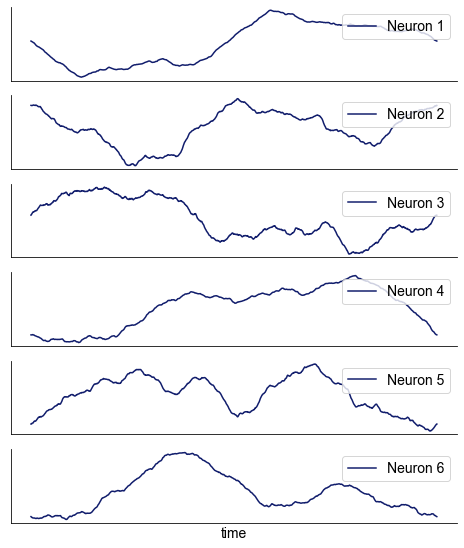

In [191]:
plt.figure(figsize=(8,16))

for i in range(6):
    signal = sim.sim_powerlaw(n_seconds=100, fs=500, exponent=-3)
    plt.subplot(10,1,i+1)
    plt.plot(signal, label = 'Neuron {}'.format(i+1))
    plt.legend(loc = 'upper right')
    plt.xticks([])
    plt.yticks([])

plt.xlabel('time')
plt.show()